# Poisson-Gamma model

## _Josep Fortiana_ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2023-03-27

### Adapted from [Brian Reich - NC State University](https://bjreich.wordpress.ncsu.edu/) - [Poisson/Gamma model](https://www4.stat.ncsu.edu/~bjreich/BSMdata/JAGS2.html)

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

# 00 - Data and model

Our objective is to describe the number $\lambda$ of animals of a given species per square mile in a state.

We sample **$ n$ square miles** of the state and observe **$y\in\{0,1,2,\dots\}$ animals** of the species of interest. 

The statistical model (likelihood and prior) is:

$$
    y\,|\,\lambda\sim\poissondist(n\cdot\lambda),\mskip50mu \lambda\sim\gammadist(\alpha,\beta).
$$

## Problem constant ($ n$) and observed data ($y$)

In [1]:
n<-20
y<-11

## Prior parameters

The expectation of a $ \gammadist(a,b)$ is $a/b$ and its variance is $a/b^2$.

In [2]:
prior.a<-0.5
prior.b<-0.5

In [3]:
prior.m<-prior.a/prior.b
prior.v<-prior.a/prior.b^2
round(prior.m,2)
round(prior.v,2)

[1] 1

[1] 2

# 01 - Exact treatment, using the conjugate property

The prior is $ \gammadist(\alpha,\beta)$. Given the observed $y$ in $n$ square miles, the posterior is: 

$$
    \lambda\,|\,y\sim\gammadist(\alpha',\beta').
$$

$$
    \left\{\begin{array}{lcl}
    \alpha'  &=& \alpha+y,\\[0.25cm]
    \beta'   &=& \beta+n.
    \end{array}\right.
$$

Therefore, the posterior mean, standard deviation, and 90% interval can be found exactly.

In [4]:
posterior.a<-prior.a+y
posterior.b<-prior.b+n

In [5]:
# Posterior mean 
round(posterior.a/posterior.b,5)                  

[1] 0.56098

In [6]:
# Posterior sd 
round(sqrt(posterior.a)/posterior.b,5)                    

[1] 0.16542

In [7]:
# Posterior (quantile-centered) 95% interval
round(qgamma(c(0.025,0.975),shape=posterior.a,rate=posterior.b),5)     

[1] 0.28509 0.92867

In [8]:
# Posterior (quantile-centered) 90% interval
round(qgamma(c(0.05,0.95),shape=posterior.a,rate=posterior.b),5)     

[1] 0.31928 0.85786

# 02 - Numerical treatment with discretization

## Discretization grid

In [9]:
# Interval [0,2] determined to contain most of the gamma probability (gamma density near 0)
# Grid of lambda values
grid<-seq(0.01,2,by=0.01)    

## Likelihood, prior, posterior

In [10]:
Lik <- dpois(y,n*grid)
Lik <- Lik/sum(Lik)      #standardize

In [11]:
Prior <- dgamma(grid,prior.a,prior.b)
Prior <- Prior/sum(Prior) #standardize

In [12]:
Joint  <- Lik*Prior

Post   <- Joint/sum(Joint)

## Plots

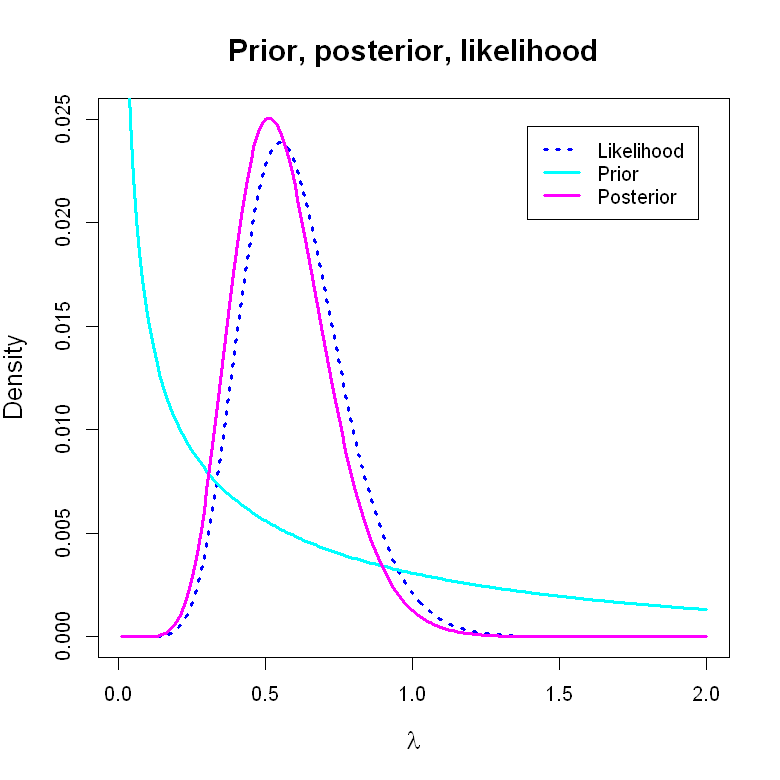

In [13]:
options(repr.plot.width=6.5,repr.plot.height=6.5)
plot(grid,Lik,type="l",lty=3,col="blue",cex.lab=1.5,lwd=3,
     ylim=c(0,0.025),xlab=expression(lambda),ylab="Density",main="Prior, posterior, likelihood",
     cex.lab=1.3,cex.main=1.5)
lines(grid,Prior,col="cyan",lwd=3)
lines(grid,Post,col="magenta",lwd=3)
legend("topright",c("Likelihood","Prior","Posterior"),lwd=c(3,3,3),lty=c(3,1,1),col=c("blue","cyan","magenta"),inset=0.05)

# 03 - JAGS treatment with `rjags`

In [14]:
#install.packages("rjags",repos= "https://cloud.r-project.org")
require(rjags)

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



## Write model data

In [15]:
Poiss.01.data<-list(y=y,n=n,a=prior.a,b=prior.b)
Poiss.01.model_string <- "model{
  # Likelihood (can't have formulas in distribution functions)
  y  ~  dpois(mu)
  mu <- n*lambda
  # Prior
  lambda ~ dgamma(a, b)
 }"

## Compile model

In [16]:
Poiss.01.model <- jags.model(textConnection(Poiss.01.model_string), data = Poiss.01.data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 6

Initializing model



## Generate and summarize samples

In [17]:
update(Poiss.01.model, 10000, progress.bar="none")

In [18]:
Poiss.01.samples <- coda.samples(Poiss.01.model,variable.names=c("lambda"),n.iter=20000, progress.bar="none")
summary(Poiss.01.samples)


Iterations = 10001:30000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      0.561084       0.165684       0.001172       0.001176 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.2878 0.4418 0.5455 0.6648 0.9268 


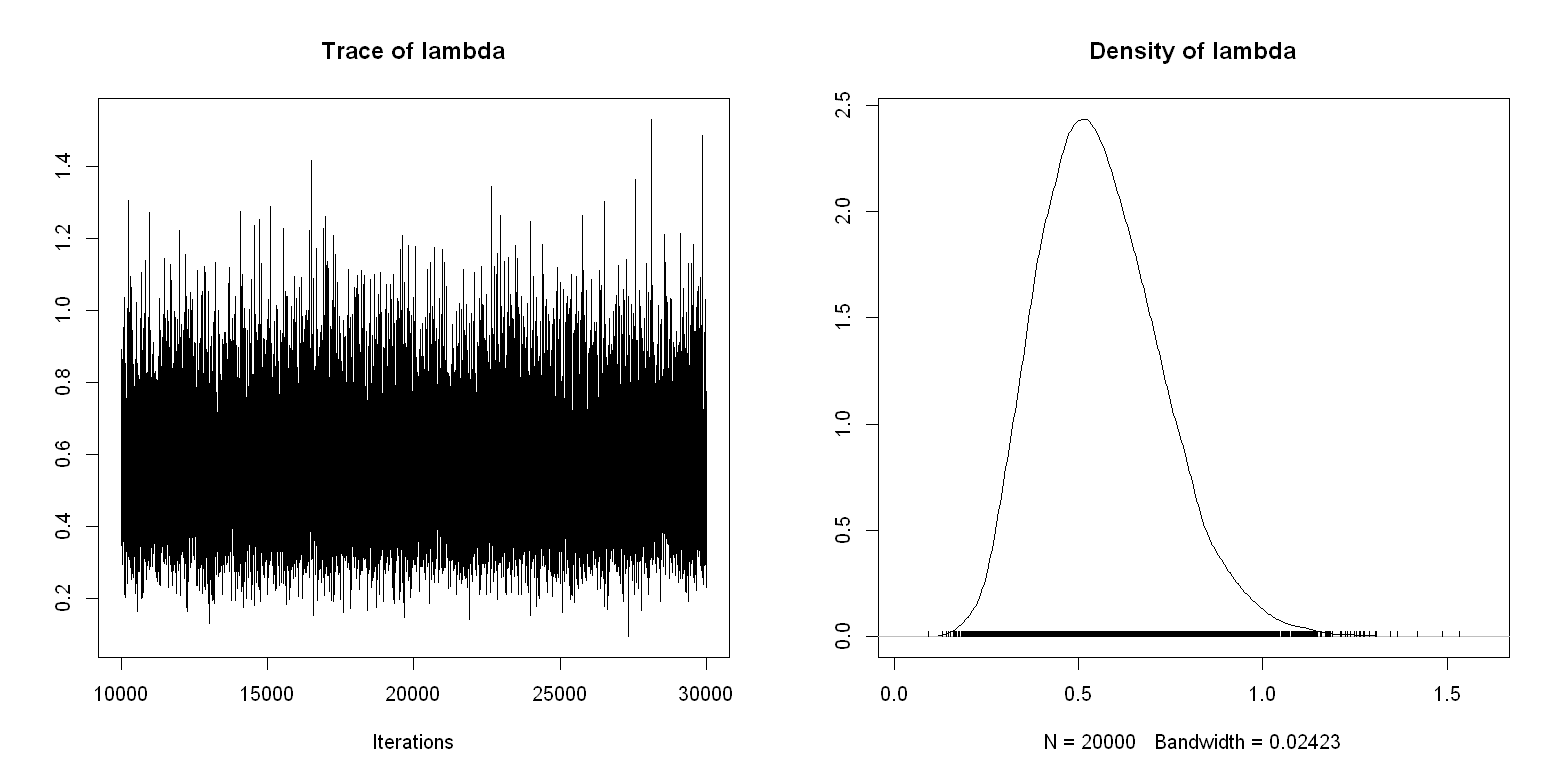

In [19]:
options(repr.plot.width=13,repr.plot.height=6.5)
plot(Poiss.01.samples)

# 04 - Stan treatment 

In [20]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan)

Loading required package: rstan

Loading required package: StanHeaders


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file


Attaching package: 'rstan'


The following object is masked from 'package:coda':

    traceplot




In [21]:
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

## Specify model

In [22]:
modelString = "
  data{
    int<lower=0> n ;
    int<lower=0> y ; 
    real<lower=0> a ;
    real<lower=0> b ;
    }
  parameters{
    real<lower=0> lambda ;
    }
  model{
    lambda ~ gamma(a,b) ;
    y ~ poisson(n*lambda) ; 
    }"

## Compile model and sample from the posterior pdf

In [23]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 

In [24]:
# Specify data:
n<-20
y<-11
prior.a<-0.5
prior.b<-0.5
a <- prior.a
b <- prior.b
dataList = list(n=n,y=y,a=a,b=b)

In [25]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = dataList, 
                     chains = 3,
                     iter = 3000, 
                     warmup = 200, 
                     thin = 1)

In [26]:
S<-summary(stanFit)
round(S$summary,5)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
lambda,0.56056,0.00306,0.16461,0.28575,0.44288,0.54540,0.66029,0.92785,2887.019,1.00115
lp__,14.30166,0.01270,0.73006,12.24820,14.14859,14.57715,14.75620,14.80468,3303.598,1.00043


# Diagnostic diagrams with the `bayesplot` package

In [27]:
#install.packages("bayesplot", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot)

Loading required package: bayesplot

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



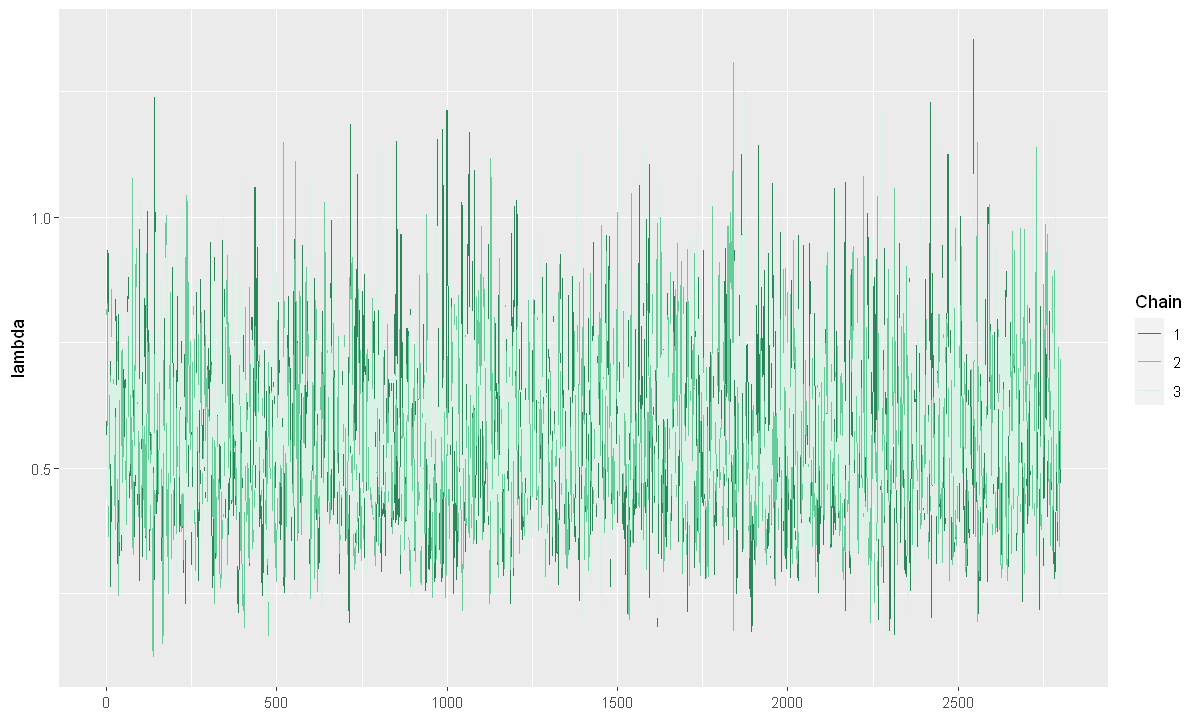

In [28]:
color_scheme_set("green")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace(stanFit, pars = c("lambda"))

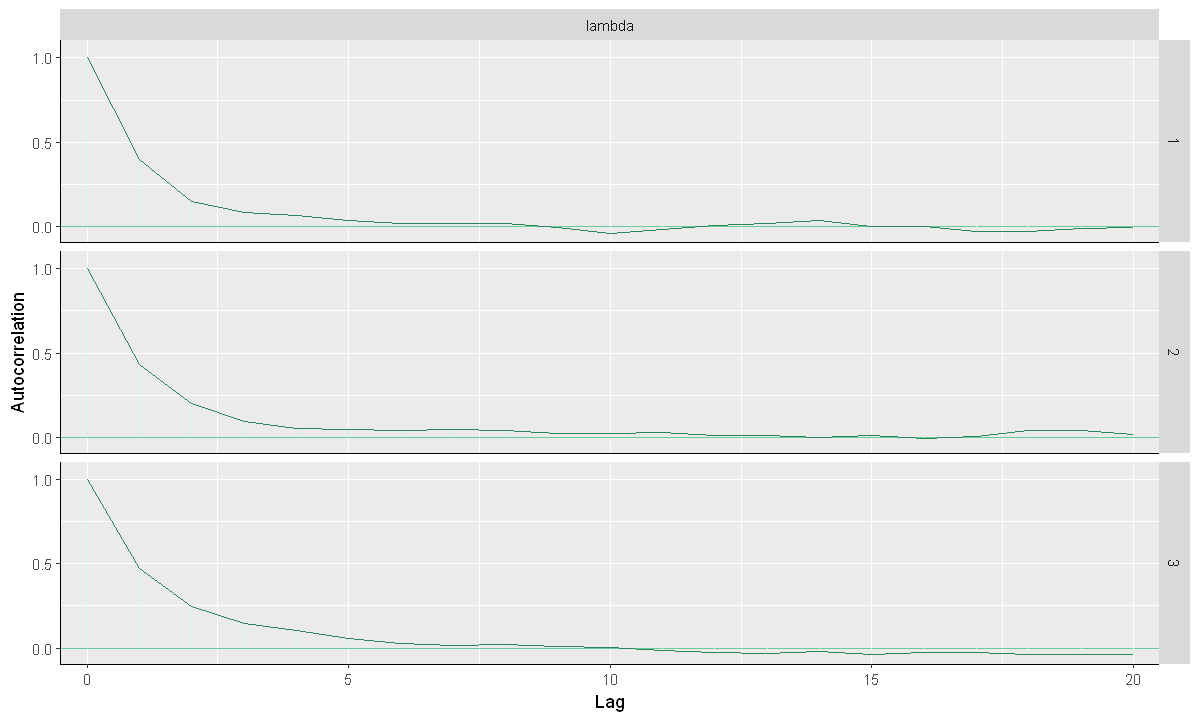

In [29]:
options(repr.plot.width=10,repr.plot.height=6)
mcmc_acf(stanFit,pars=c("lambda"))

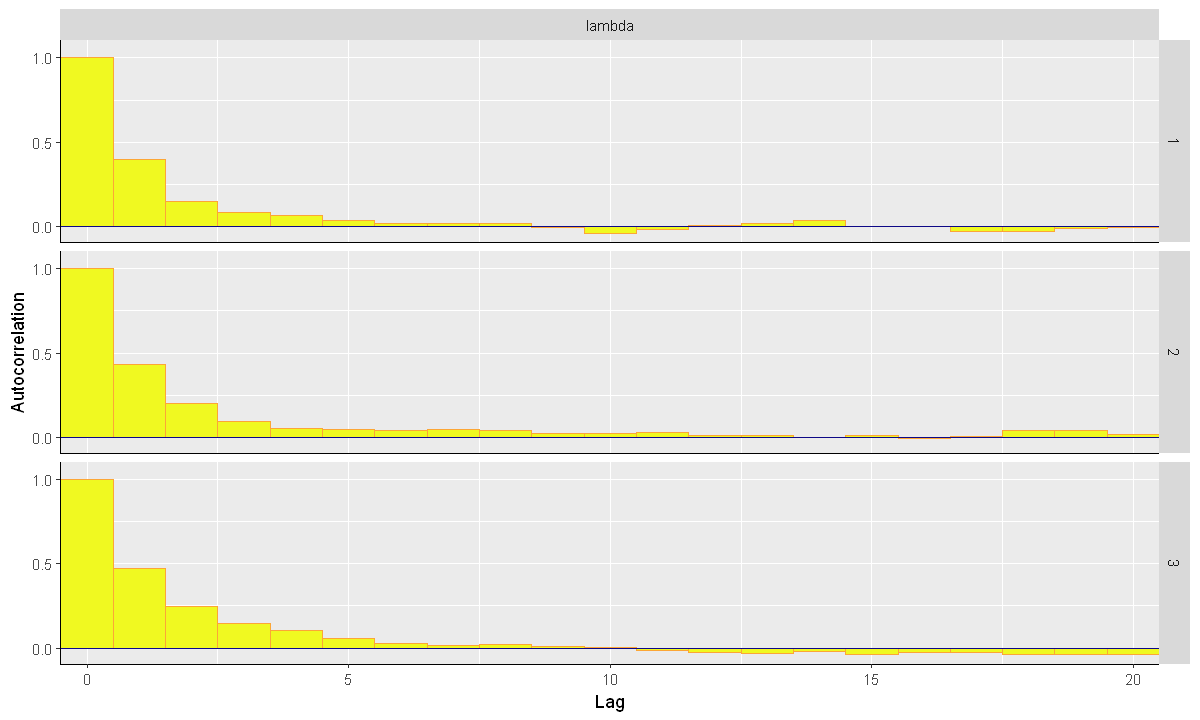

In [30]:
color_scheme_set("viridisC")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_acf_bar(stanFit,pars=c("lambda"))

# Analysis of posterior pdf properties

### Posterior credible interval 

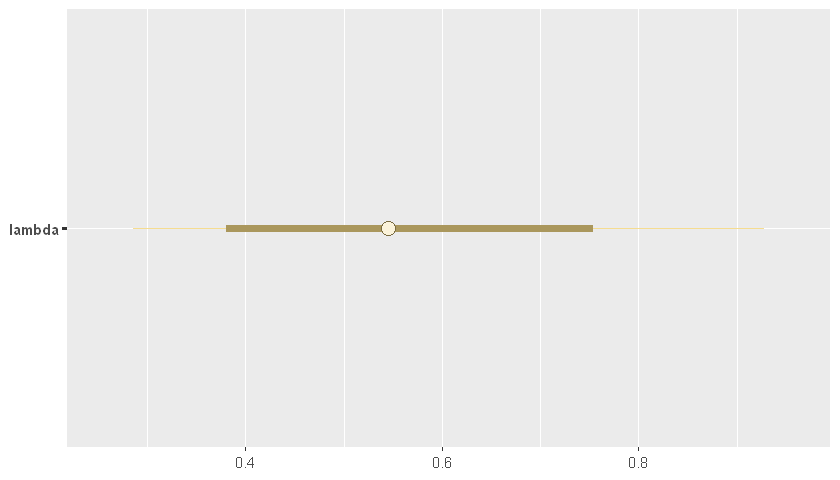

In [31]:
color_scheme_set("yellow")
options(repr.plot.width=7,repr.plot.height=4)
mcmc_intervals(stanFit, pars = c("lambda"),prob=0.75,prob_outer=0.95)
# Defaults are
# prob = 0.5,
# prob_outer = 0.9,

### Areas diagram

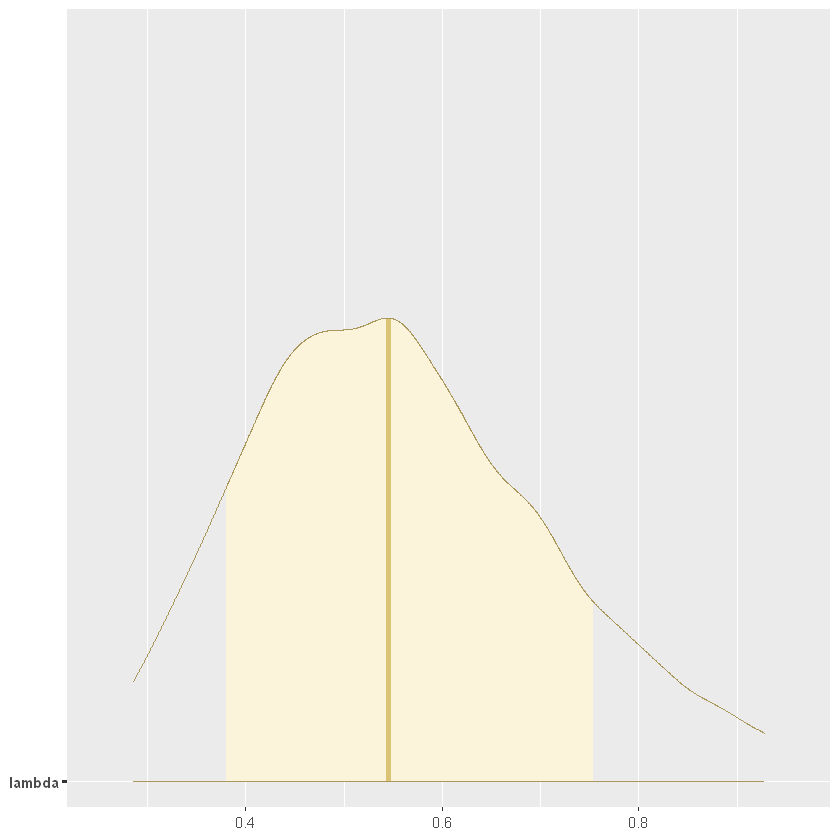

In [32]:
options(repr.plot.width=7,repr.plot.height=7)
mcmc_areas(stanFit, pars = c("lambda"),prob=0.75,prob_outer=0.95)

### Histogram

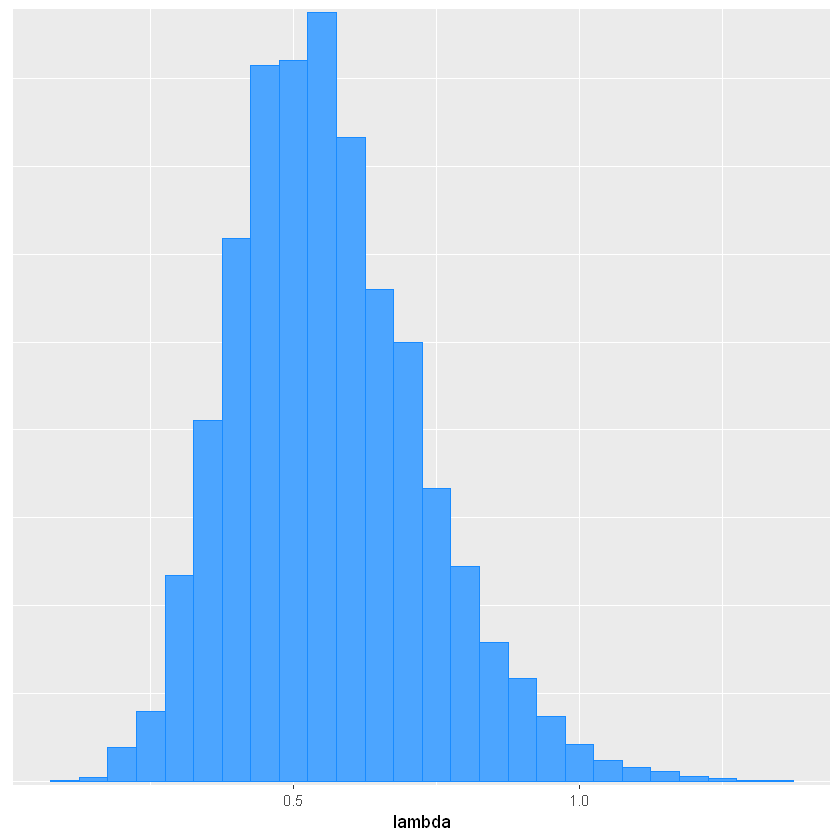

In [33]:
color_scheme_set("brightblue")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_hist(stanFit, pars = c("lambda"),binwidth=0.05)

### Density plot

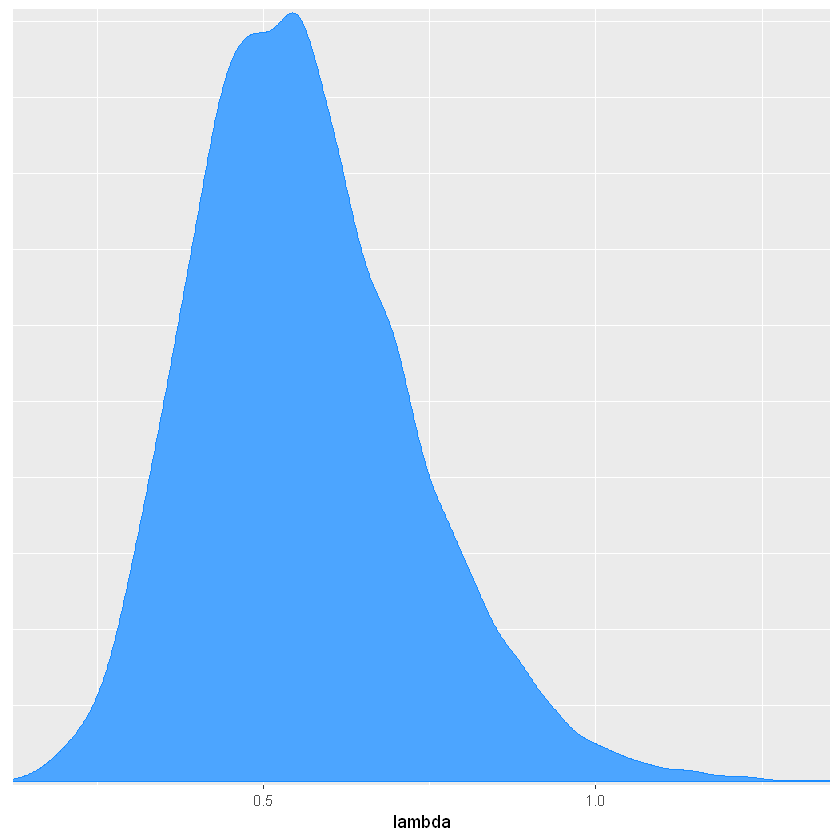

In [34]:
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens(stanFit, pars = c("lambda"))

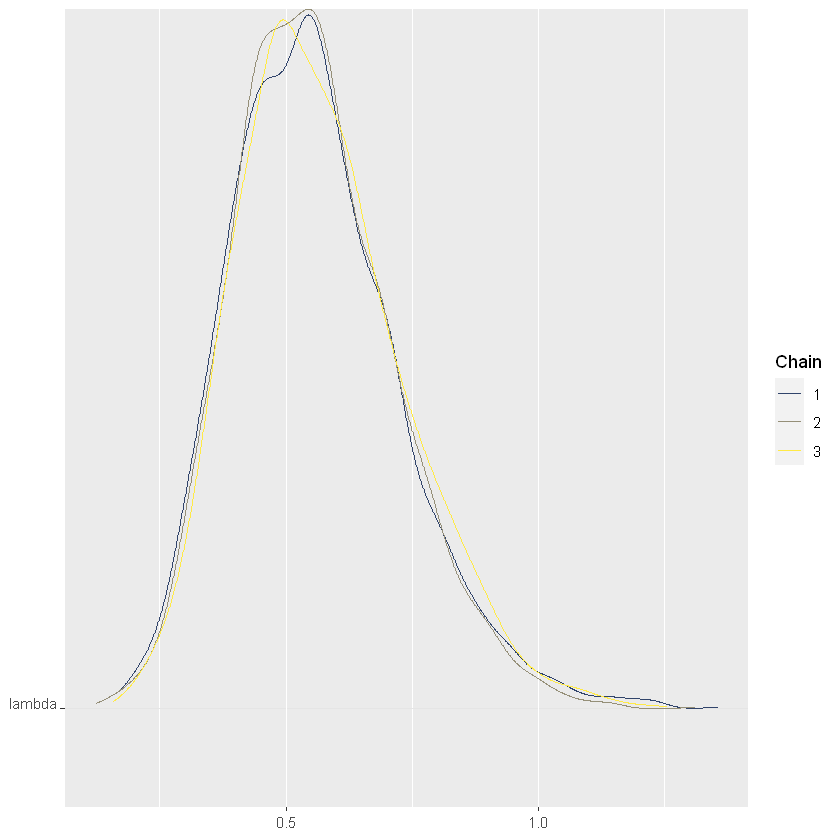

In [35]:
color_scheme_set("viridisE")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens_chains(stanFit, pars = c("lambda"))

### Violin plot

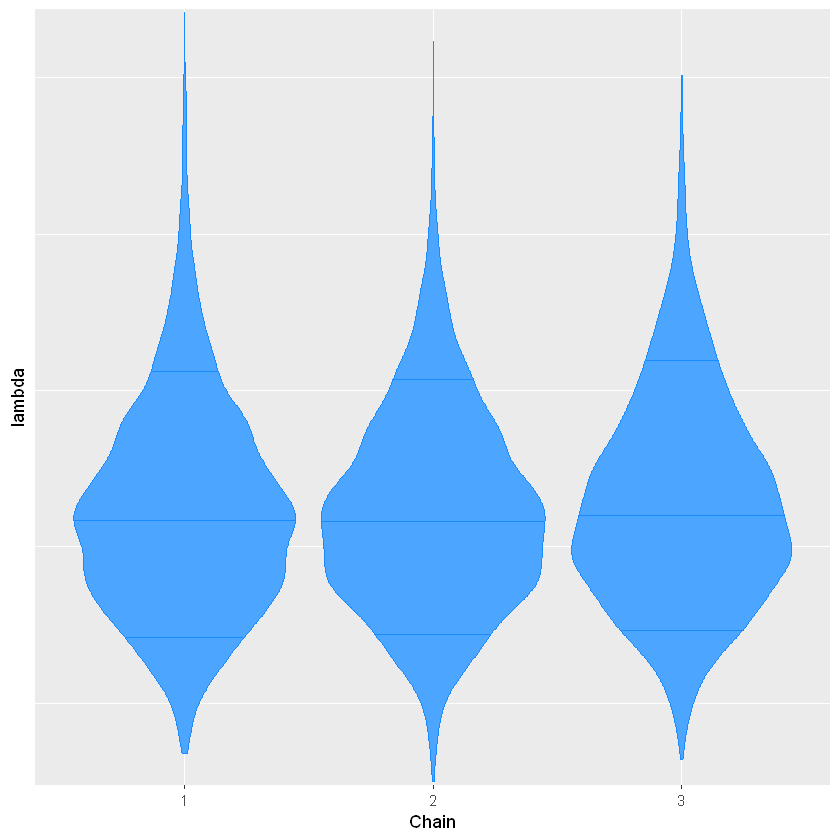

In [36]:
color_scheme_set("brightblue")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_violin(stanFit, pars = c("lambda"))